# Symbolic Regression Problem: Introduction to GP using DEAP


Symbolic regression is one of the best known problems in GP. It is commonly used as a tuning problem for new algorithms, but is also widely used with real-life distributions, where other regression methods may not work. It is conceptually a simple problem, and therefore makes a good introductory example for the GP framework in DEAP.

All symbolic regression problems use an arbitrary data distribution, and try to fit the most accurately the data with a symbolic formula. Usually, a measure like the RMSE (Root Mean Square Error) is used to measure an individual’s fitness.

In this example, we use a classical distribution, the quartic polynomial (x^4 + x^3 + x^2 + x), a one-dimension distribution. 20 equidistant points are generated in the range [-1, 1], and are used to evaluate the fitness.

<hr/>
<p>Symbolic Regression with Genetic Programming</p>
<div class="container-fluid">
  <div class='well'>
      <div class="row">
          <div class="col-md-12" align='center'>
              <img align='center'alt=“Genetic Programming“ style="border-width:0" src="http://inspirehep.net/record/1421690/files/trees.png"/>
          </div>
      </div>
  </div>
</div>


# Creating the primitives set

One of the most crucial aspect of a GP program is the choice of the primitives set. They should make good building blocks for the individuals so the evolution can succeed. In this problem, we use a classical set of primitives, which are basic arithmetic functions:

In [1]:
# first, our imports
import operator
import math
import random
import numpy as np
from deap import algorithms, base, creator, tools, gp

def protectedDiv(left, right):
    try:
        return left / right
    except ZeroDivisionError:
        return 1

pset = gp.PrimitiveSet("MAIN", 1)
pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(operator.mul, 2)
pset.addPrimitive(protectedDiv, 2)
pset.addPrimitive(operator.neg, 1)
pset.addPrimitive(math.cos, 1)
pset.addPrimitive(math.sin, 1)
pset.addEphemeralConstant("rand101", lambda: random.randint(-1,1))

/home/osboxes/.virtualenvs/Python2/local/lib/python2.7/site-packages/deap/tools/_hypervolume/pyhv.py:33: ImportWarning: Falling back to the python version of hypervolume module. Expect this to be very slow.
  "module. Expect this to be very slow.", ImportWarning)


The redefinition of the division is made to protect it against a zero division error (which would crash the program). The other functions are simply a mapping from the Python **operator** module. The number following the function is the arity of the primitive, that is the number of entries it takes.

On the last line, we declare an **Ephemeral** constant. This is a special terminal type, which does not have a fixed value. When the program appends an ephemeral constant terminal to a tree, the function it contains is executed, and its result is inserted as a constant terminal. In this case, those constant terminals can take the values -1, 0 or 1.

The second argument of **PrimitiveSet** is the number of inputs. Here, as we have only a one dimension regression problem, there is only one input, but it could have as many as you want. By default, those inputs are named **“ARGx”**, where **“x”** is a number, but you can easily rename them :

In [2]:
pset.renameArguments(ARG0='x')

# Creator

As any evolutionary program, symbolic regression needs (at least) two object types : an individual containing the genotype and a fitness. We can easily create them with the creator:

In [3]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

The first line creates the fitness object (this is a minimization problem, so the weight is negative). The weights argument must be an iterable of weights, even if there is only one fitness measure. The second line create the individual object itself. Very straightforward, we can see that it will be based upon a tree, to which we add a fitness. If, for any reason, the user would want to add any other attribute (for instance, a file in which the individual will be saved), it would be as easy as adding this attribute of any type to this line. After this declaration, any individual produced will contain those wanted attributes.

# Toolbox

Now, we want to register some parameters specific to the evolution process. In DEAP, this is done through the toolbox:

In [4]:
toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

# Even if the fitness only contains one measure, keep in mind that DEAP 
# stores it as an iterable. Knowing that, you can understand why the evaluation 
# function must return a tuple value (even if it is a 1-tuple):
def evalSymbReg(individual, points):
    # Transform the tree expression in a callable function
    func = toolbox.compile(expr=individual)
    # Evaluate the mean squared error between the expression
    # and the real function : x**4 + x**3 + x**2 + x
    sqerrors = ((func(x) - x**4 - x**3 - x**2 - x)**2 for x in points)
    return math.fsum(sqerrors) / len(points),

toolbox.register("evaluate", evalSymbReg, points=[x/10. for x in range(-10,10)])
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))

First, a toolbox instance is created (in some problem types like coevolution, you may consider creating more than one toolbox). Then, we can register any parameters. The first lines register how to create an individual (by calling **gp.genRamped** with the previously defined primitive set), and how to create the population (by repeating the individual initialization).

We may now introduce the evaluation function, which will receive an individual as input, and return the corresponding fitness. This function uses the compile function previously defined to transform the individual into its executable form – that is, a program. After that, the evaluation is only simple maths, where the difference between the values produced by the evaluated individual and the real values are squared and summed to compute the RMSE, which is returned as the fitness of the individual.

Afterwards, we register the evaluation function. We also choose the selection method (a tournament of size 3), the mate method (one point crossover with uniform probability over all the nodes), the mutation method (an uniform probability mutation which may append a new full sub-tree to a node).

Then, we decorate the mate and mutate method to limit the height of generated individuals. This is done to avoid an important draw back of genetic programming : bloat. Koza in his book on genetic programming suggest to use a max depth of 17.

At this point, any structure with an access to the toolbox instance will also have access to all of those registered parameters. Of course, the user could register other parameters basing on his needs.

# Statistics

Although optional, statistics are often useful in evolutionary programming. DEAP offers a simple class which can handle most of the “boring work”. In this case, we want to compute the mean, standard deviation, minimum, and maximum of both the individuals fitness and size. For that we’ll use a **MultiStatistics** object.

In [5]:
stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg", np.mean)
mstats.register("std", np.std)
mstats.register("min", np.min)
mstats.register("max", np.max)

# Launching the evolution

At this point, DEAP has all the information needed to begin the evolutionary process, but nothing has been initialized. We can start the evolution by creating the population and then calling a complete algorithm. In this case, we’ll use **eaSimple()**.

The hall of fame is a specific structure which contains the n best individuals (here, the best one only).

In [6]:
verbose = False
pop = toolbox.population(n=300)
hof = tools.HallOfFame(1)  # we only want the best individual
pop, log = algorithms.eaSimple(pop, 
                               toolbox, 
                               0.5, 
                               0.1, 
                               40, 
                               stats=mstats,
                               halloffame=hof, 
                               verbose=verbose)

# see the best solution
print(hof[0])

mul(add(mul(x, x), 1), mul(add(x, 1), x))


# Visualizing the result

Note, this requires `graphviz` to be installed on the system!

/home/osboxes/.virtualenvs/Python2/local/lib/python2.7/site-packages/scipy/optimize/_minimize.py:32: ImportWarning: Not importing directory '/home/osboxes/.virtualenvs/Python2/local/lib/python2.7/site-packages/scipy/optimize/lbfgsb': missing __init__.py
  from .lbfgsb import _minimize_lbfgsb
/home/osboxes/.virtualenvs/Python2/local/lib/python2.7/site-packages/scipy/spatial/__init__.py:95: ImportWarning: Not importing directory '/home/osboxes/.virtualenvs/Python2/local/lib/python2.7/site-packages/scipy/spatial/qhull': missing __init__.py
  from .qhull import *


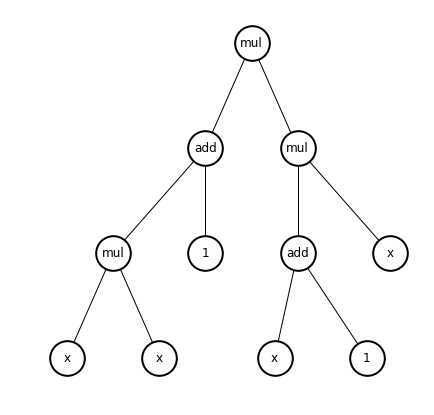

In [7]:
import networkx
import matplotlib.pyplot as plt
from networkx.drawing.nx_agraph import graphviz_layout

%matplotlib inline

nodes, edges, labels = gp.graph(hof[0])
graph = networkx.Graph()
graph.add_nodes_from(nodes)
graph.add_edges_from(edges)
pos = graphviz_layout(graph, prog="dot")

plt.figure(figsize=(7, 7))
diagram = networkx.draw_networkx_nodes(graph, pos, node_size=1200, node_color="w", linewidths=2.0)

diagram.set_edgecolor('k')
networkx.draw_networkx_edges(graph, pos)
networkx.draw_networkx_labels(graph, pos, labels)
plt.axis("off")
plt.show()


# Multiprocessing

Increase the performance of your computations by prepending the following code before evaluation. Note that processes are roughly analogous to virtual CPUs. In other words, if you have a quad-core computer using 4 processes is good. Using more may slow down your calculation overall.

```
import multiprocessing

# define the number of processes you want to use here
pool = multiprocessing.Pool(processes=4)
toolbox.register("map", pool.map)
```

# Activity 1: Find the solution which fits the data from "*`function_data1.txt`*". Define / use any operators you may need. Evaluate / plot the best fit solution against the input data.
Hint: instead of comparing each chromosome against an exact function, compare the chromosomes against the data contained in the file "*`function_data1.txt`*" when fitting.

# Activity 2: Find the solution which fits the data from "*`function_data2.txt`*" against a chromosome which takes 2 arguments when fitting. Define / use any operators you may need. Evaluate / plot the best fit solution against the input data.
Hint: Instead of using a list of 1D points, you may need to create a list of 2D points which will be evaluated over a known range.

In [12]:
text_file = open("function_data1.txt", "r")
lines = text_file.readlines()
lines=[float(x) for x in lines]
text_file.close()
print(lines[1])
type(lines[0])

-810.001110688


float

# Extra: Use the `sympy` package to simplify and beautify the best fit solution.

# Reference
John R. Koza, *“Genetic Programming: On the Programming of Computers by Means of Natural Selection”, MIT Press, 1992, pages 162-169.*